run sub experinents to add noise to the boundary data and see what happens to the distribution at the end.

send professional picture

In [102]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(4, 4)})

import warnings

warnings.filterwarnings('ignore')


batch_size = 16

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_ic = 1
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.numInputs = 2
        self.numParams = 2
        self.numOutputs = 1
        self.hidden_size = 25

        self.t0 = torch.tensor([0.0], requires_grad=True).to(self.device)
        self.y0 = torch.tensor([1.0], requires_grad=True).to(self.device)

        self.predicted_params = torch.zeros(self.numParams, requires_grad=True)

        # We only have 1 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(1, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)

        nn.init.ones_(self.b1.weight)
        nn.init.ones_(self.b2.weight)
        nn.init.ones_(self.b3.weight)

        nn.init.ones_(self.t1.weight)
        nn.init.ones_(self.t2.weight)
        nn.init.ones_(self.t3.weight)

    # make this static so that it can be called independently
    @staticmethod
    def exact_solution(t, x):
        return torch.exp(-t) * torch.sin(torch.pi * x)

    def forward(self, t, x):
        if not torch.is_tensor(t):
            t = torch.from_numpy(t).float().to(self.device)

        if not torch.is_tensor(x):

            x = torch.from_numpy(x).float().to(self.device)
            

        input = torch.cat((t, x), 1)

        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        prior_param_sample = torch.rand(1, 1, device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample.squeeze()

        y = self.b3(torch.multiply(t2, h2))

        return y

    def sample_parameter_posterior(self, num_samples=100):
        prior_param_sample = torch.rand(num_samples, 1, device=self.device).requires_grad_(True)
        posterior_param_sample = self.t3(torch.tanh(self.t2(torch.tanh(self.t1(prior_param_sample)))))
        return posterior_param_sample

    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(dy_dx, x, n - 1)

    def PDE_residual(self, t, x):
        y = self.forward(t, x)
        dy_dt = self.compute_derivative(y, t, 1)
        dy_dx = self.compute_derivative(y, x, 1)
        d2y_dx2 = self.compute_derivative(y, x, 2)

#         residual = dy_dt - self.predicted_params[1] * d2y_dx2 \
#             + torch.exp(-self.predicted_params[0] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))
#       

        residual = dy_dt - d2y_dx2  + torch.exp(-self.predicted_params[0] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))
        return residual

    def loss_initial_condition(self, num_samples=200):
        t0 = self.t0 * torch.ones((num_samples, 1), device = self.device)
#         x = torch.FloatTensor(num_samples, 1).uniform_(-1, 1).to(self.device).requires_grad_(True)
        x = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        y0_pred = self.forward(t0, x)
        y0_true = self.exact_solution(t0, x)
        loss_ic = torch.mean(torch.square(y0_true - y0_pred))
        return loss_ic

    def loss_boundary_condition(self, num_samples=200):
        x_low = -1
        x_high = 1
        xb_low   = x_low * torch.ones((num_samples, 1),  device = self.device)
        xb_high  = x_high * torch.ones((num_samples, 1), device = self.device)

#         t = torch.FloatTensor(num_samples, 1).uniform_(-1, 1).to(self.device)
        t = torch.rand((num_samples, 1),   device=self.device).requires_grad_(True)

        yb_low = self.exact_solution(t, xb_low)
        yb_high = self.exact_solution(t, xb_high)

        yb_pred_low = self.forward(t, xb_low)
        yb_pred_high = self.forward(t, xb_high)

        loss_ic = torch.mean(torch.square(yb_pred_low - yb_low)) \
                + torch.mean(torch.square(yb_pred_high - yb_high))

        return loss_ic

    def compute_losses(self):
        loss_ic = self.loss_initial_condition()
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_ic, loss_interior, loss_data, loss_bc

    def loss_data(self, num_samples=20):
        t_data, x_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data, x_data)
        loss = torch.mean(torch.square(y_pred - y_data))
        return loss

    def loss_interior(self, num_samples=1000):
        
#        interior_t_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).to(self.device).requires_grad_(True)
        interior_t_samples = torch.rand((num_samples, 1),   device=self.device).requires_grad_(True)
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
#         interior_x_samples = torch.FloatTensor(num_samples, 1).uniform_(-1, 1).to(self.device).requires_grad_(True)
        res = self.PDE_residual(interior_t_samples, interior_x_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual

    def closure(self):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_ic * loss_ic \
                   + self.w_int * loss_interior \
                   + self.w_data * loss_data \
                   + self.w_bc * loss_bc

        total_loss.backward(retain_graph=True)
        return total_loss

    def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 4000 == 0:
                loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data + loss_bc
                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')

    def make_plot(self):
        t_test, x_test, y_test = sample_dataset(noise=0.0, device = self.device)
        mu = self.forward(t_test, x_test)

        fig = plt.figure(figsize=(6, 3))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122, sharex=ax1)
        size = int(np.sqrt(x_test.size(0)))

        # Reshape mu and y_test to 2D grids
        # mu = mu.view(size, size).cpu().detach().numpy()
        # y_test = y_test.view(size, size).cpu().detach().numpy()

        ax1.contourf(t_test.view(size, size).cpu().detach().numpy(),
                     x_test.view(size, size).cpu().detach().numpy(),
                     mu.view(size, size).cpu().detach().numpy())

        plt.xlabel('t');plt.ylabel('x')
        ax1.get_shared_x_axes().join(ax1, ax2)

        ax2.contourf(t_test.view(size, size).cpu().detach().numpy(),
                     x_test.view(size, size).cpu().detach().numpy(),
                     y_test.view(size, size).cpu().detach().numpy())

        # plt.colorbar();


In [103]:
def sample_dataset(noise=0.1, numSamples=100, device='cpu'):
    t = torch.linspace(0, 1, numSamples, device=device) # Time domain
    x = torch.linspace(-1, 1, numSamples, device=device) # Space domain

    T, X = torch.meshgrid(t, x) # Time-Space domain

    y_true = Experiment.exact_solution(T, X)
    T = T.reshape(-1, 1) # Reshape to 2D to 1D
    X = X.reshape(-1, 1) # Resahpe to 2D to 1D

    sample_mean = y_true.reshape(-1, 1)
    sample_var = noise * torch.ones_like(sample_mean)
    Y_noisy = torch.normal(sample_mean, sample_var)

    return T, X, Y_noisy


def create_train_test_datasets(device='cpu'):
    t_train, x_train, y_train = sample_dataset(noise=0.01, numSamples=10, device=device)
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    fig = plt.figure()
    size = int(t_test.size(0)**0.5)


    plt.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy())
    plt.xlabel('t'); plt.ylabel('x');
    plt.colorbar()

    train_dataset = TensorDataset(t_train, x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t_test, x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [104]:
net = Experiment()
net.to('cuda:0')  # Explicitly set the device to 'cuda:0'
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

cuda:0
Params: 1503


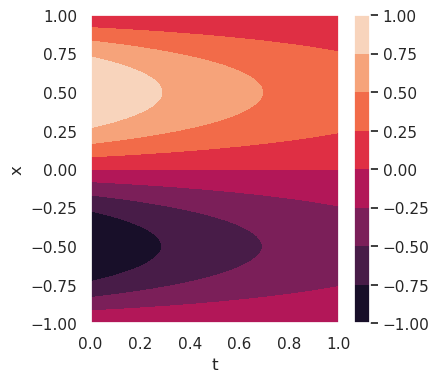

In [105]:
train_loader, test_loader = create_train_test_datasets(device = net.device)

In [106]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [107]:
net.w_ic = 1
net.w_data = 1

In [ ]:
net.train(70000, optimizer='Adam', lr=1e-2)

Epoch (Adam): 0, Total Loss: 2712360.0
Epoch (Adam): 4000, Total Loss: 10118980.0
Epoch (Adam): 8000, Total Loss: 22190324.0
Epoch (Adam): 12000, Total Loss: 196288.40625
Epoch (Adam): 16000, Total Loss: 205218.53125
Epoch (Adam): 20000, Total Loss: 17535.56640625
Epoch (Adam): 24000, Total Loss: 3480.14404296875
Epoch (Adam): 28000, Total Loss: 1156.236572265625
Epoch (Adam): 32000, Total Loss: 1010.3281860351562
Epoch (Adam): 36000, Total Loss: 1386.94482421875
Epoch (Adam): 40000, Total Loss: 589.5353393554688
Epoch (Adam): 44000, Total Loss: 193.68080139160156
Epoch (Adam): 48000, Total Loss: 20.284509658813477


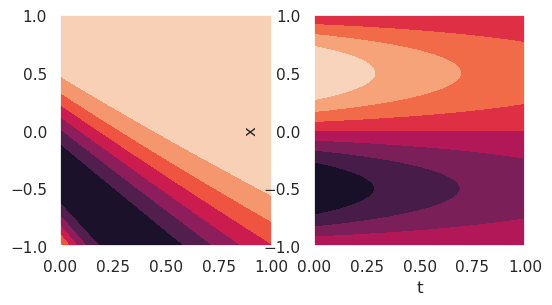

In [93]:
net.make_plot()
# samples = net.sample_parameter_posterior(num_samples=1000).detach().cpu()

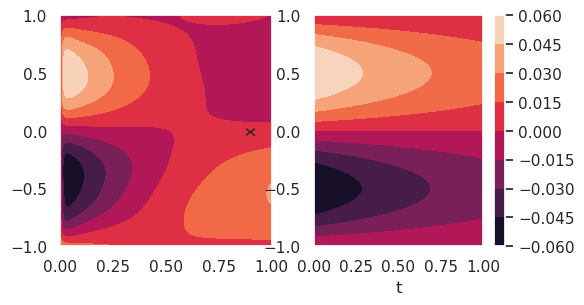

In [65]:
t_test, x_test, y_test = sample_dataset(noise=0.0, device = 'cuda:0')
mu = net.forward(t_test, x_test)

fig = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharex=ax1)
size = int(np.sqrt(x_test.size(0)))

# Reshape mu and y_test to 2D grids
# mu = mu.view(size, size).cpu().detach().numpy()
# y_test = y_test.view(size, size).cpu().detach().numpy()

cax = ax1.contourf(t_test.view(size, size).cpu().detach().numpy(),
             x_test.view(size, size).cpu().detach().numpy(),
             (mu-y_test).view(size, size).cpu().detach().numpy())

plt.colorbar(cax)
plt.xlabel('t');plt.ylabel('x')
ax1.get_shared_x_axes().join(ax1, ax2)

ax2.contourf(t_test.view(size, size).cpu().detach().numpy(),
             x_test.view(size, size).cpu().detach().numpy(),
             y_test.view(size, size).cpu().detach().numpy())



In [67]:
net.predicted_params.data

tensor([1.1970e+02, 1.1102e-01], device='cuda:0')

tensor([94.5349,  0.1167], device='cuda:0', grad_fn=<SqueezeBackward0>)

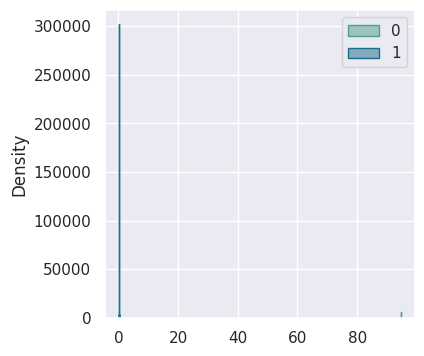

In [44]:
g  = sns.kdeplot(samples, fill=True, palette="crest",
                 alpha=.5, linewidth=1)
net.predicted_params

In [45]:
x, t, y  = next(iter(train_loader))
net(t, x) - Experiment.exact_solution(t,x)

tensor([[0.0345],
        [0.0320],
        [0.0661]], device='cuda:0', grad_fn=<SubBackward0>)

In [46]:
x = torch.linspace(-1, 1, 100).reshape(-1, 1)
t = torch.linspace(0, 1, 100).reshape(-1, 1)

X, T = torch.meshgrid(x[:, 0], t[:, 0])

y_true = Experiment.exact_solution(T, X)

In [47]:
net(t,x);